In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox
from sktime.transformations.series.boxcox import BoxCoxTransformer
from ipywidgets import interact
import ipywidgets as widgets
from math import sqrt, exp
import jax.numpy as jnp
from jax import grad

mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["axes.grid"] = False
# disable warnings
import warnings

warnings.filterwarnings("ignore")

c:\Users\triro\anaconda3\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# loading the data

In [96]:
def parse(x):
    return datetime.strptime(x, "%Y-%m-%d")


df = pd.read_csv("./data/FB.csv", parse_dates=["Date"], date_parser=parse)
df = df[["Date", "Close"]].set_index("Date")
df

,Close
Date,
2012-07-09,31.730000
2012-07-10,32.169998
2012-07-11,31.469999
2012-07-12,30.969999
2012-07-13,30.809999
...,...
2018-11-21,132.429993
2018-11-23,134.820007
2018-11-26,131.729996


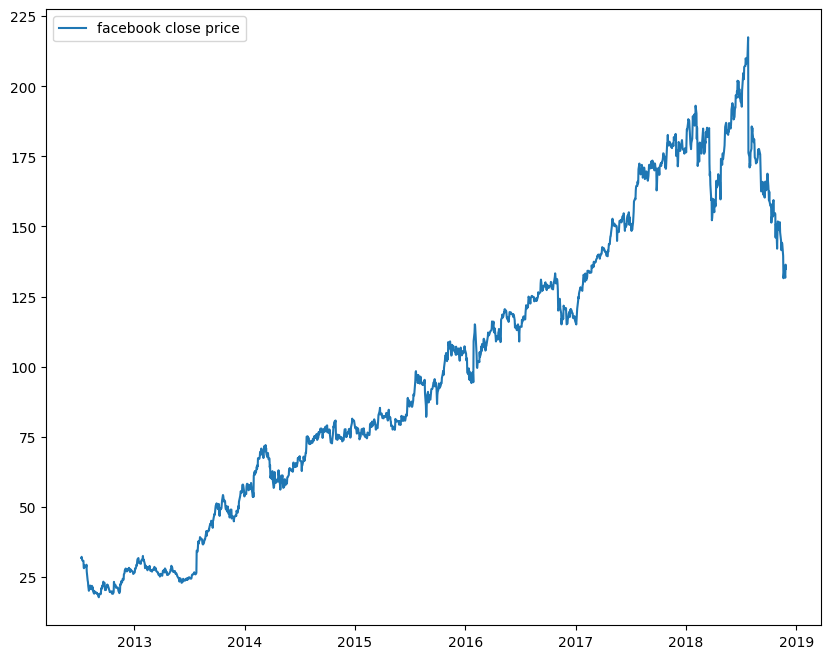

In [97]:
plt.plot(df, label="facebook close price")
plt.legend(loc="best")
plt.show()

In [98]:
# 80:20 split
train = df[: int(len(df) * 0.8)]
print(train.tail())
test = df[int(len(df) * 0.8) :]
print(test.head())
print(len(train), len(test))

                 Close
Date                  
2017-08-14  168.080002
2017-08-15  170.750000
2017-08-16  171.000000
2017-08-17  170.000000
2017-08-18  166.910004
                 Close
Date                  
2017-08-21  167.410004
2017-08-22  167.779999
2017-08-23  169.639999
2017-08-24  168.710007
2017-08-25  167.740005
1286 322


# mean method: 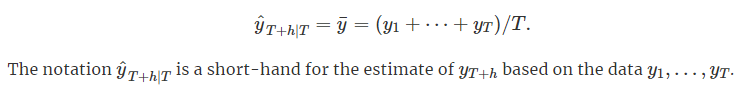

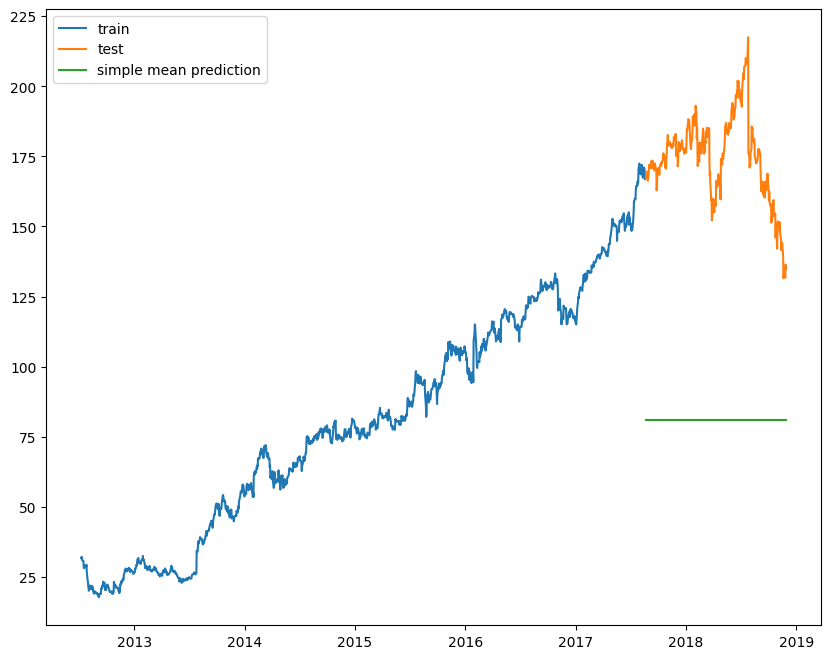

In [99]:
# calculate the mean of the training data and make the predictions equal to that and preserve the index of the test data in the predictions
pred = test.copy()
pred[:] = train.mean()
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(pred, label="simple mean prediction")
plt.legend(loc="best")
plt.show()

# Naïve method: 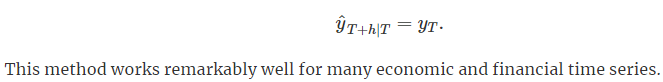

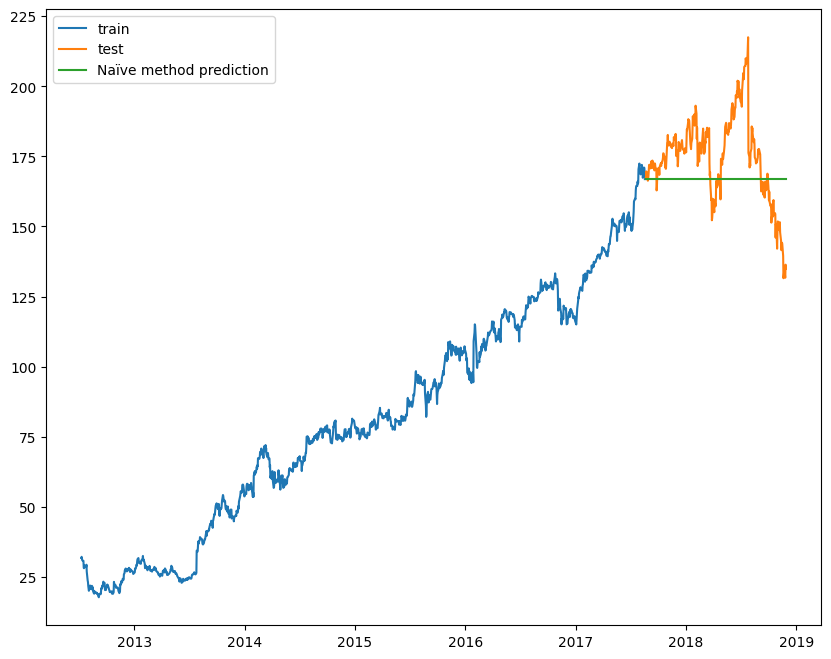

In [100]:
pred = test.copy()
pred[:] = train.iloc[-1]
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(pred, label="Naïve method prediction")
plt.legend(loc="best")
plt.show()

# Seasonal naïve method: 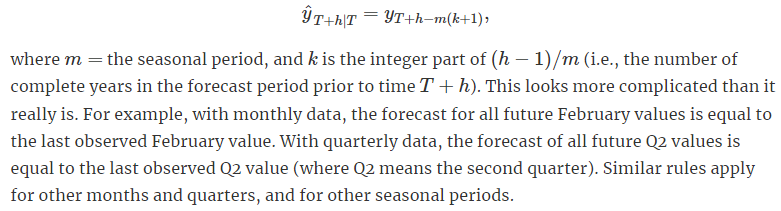

# we see some seasonality if we take period annually

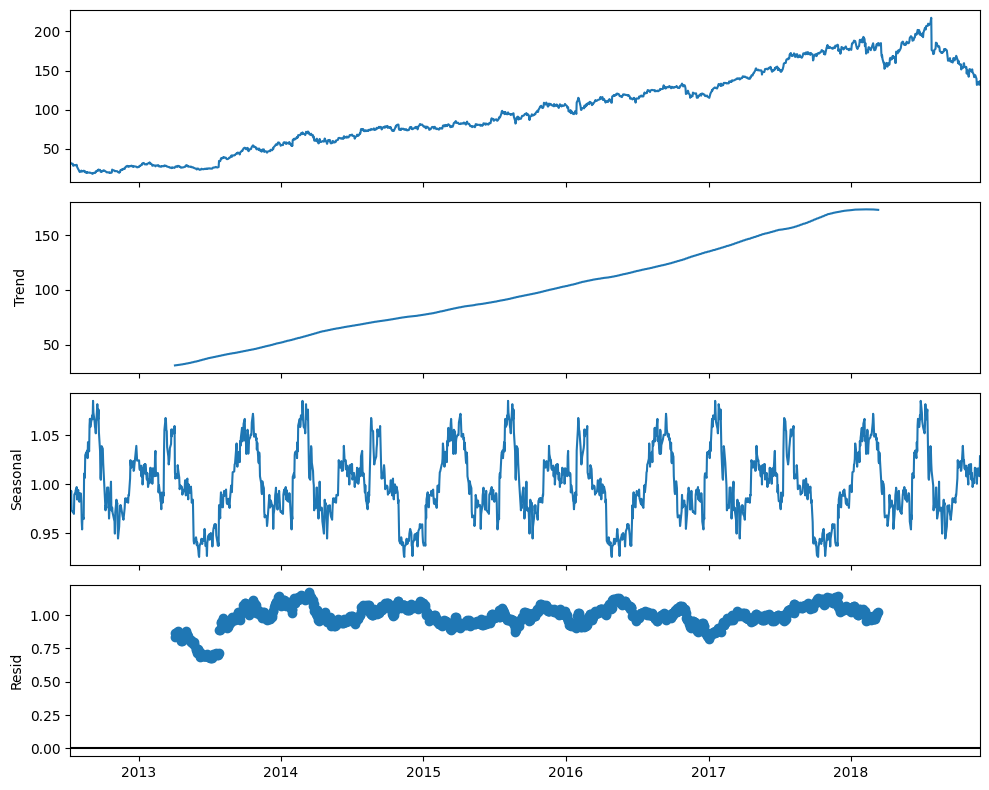

In [101]:
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
df
res = sm.tsa.seasonal_decompose(df, model="multiplicative", period=365)

resplot = res.plot()

# measuring the strength of the seasonality

In [102]:
seasonal_strength = max(0, 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid)))
seasonal_strength

0.1511934772474336

# very weak seasonality so most likely Seasonal naïve method won't be a good fit

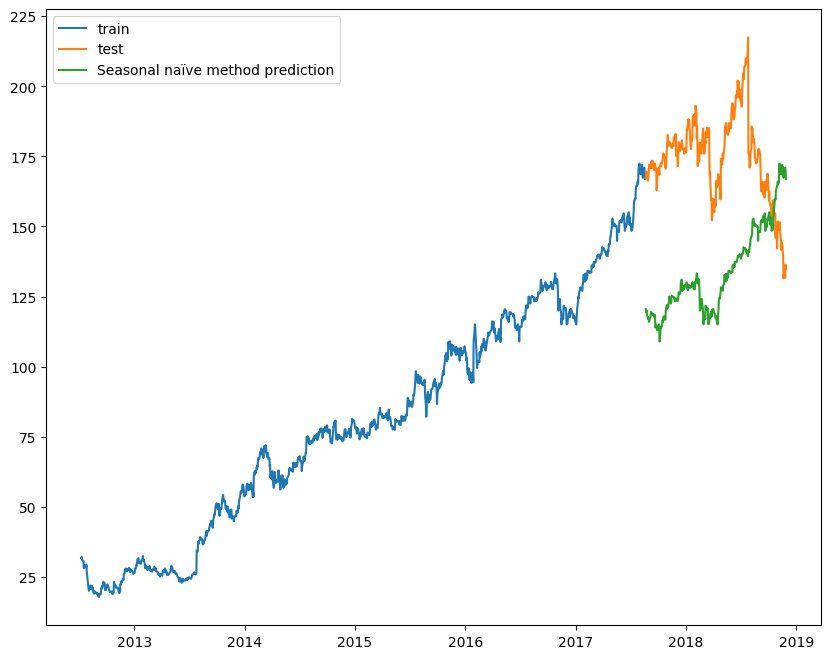

In [103]:
# repeat the last 365 days of the training data throughout the prediction series
pred = np.repeat(train.iloc[-322:], 1, axis=0)
pred = pd.DataFrame(pred, index=test.index, columns=["Close"])
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(pred, label="Seasonal naïve method prediction")
plt.legend(loc="best")
plt.show()

In [104]:
def parse(x):
    return datetime.strptime(x, "%Y-%m-%d")


df = pd.read_csv("./data/tourism.csv", parse_dates=["Quarter"], date_parser=parse)
df.drop(["Unnamed: 0", "Region", "State", "Purpose"], axis=1, inplace=True)
df = df.groupby("Quarter").sum().reset_index().set_index("Quarter")
df.sort_index(inplace=True)
df

,Trips
Quarter,
1998-01-01,23932.544141
1998-04-01,20856.726540
1998-07-01,20222.802189
1998-10-01,21342.960517
1999-01-01,22801.711403
...,...
2015-10-01,25759.429177
2016-01-01,27492.360374
2016-04-01,24791.797758


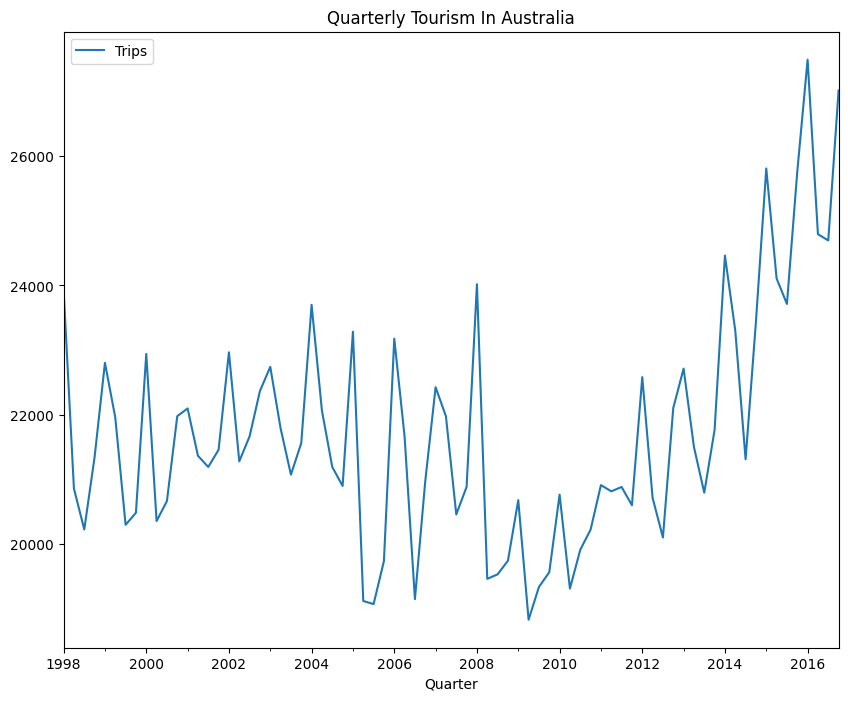

In [105]:
df.plot(title="Quarterly Tourism In Australia")
plt.legend()
plt.show()

# trying the Seasonal naïve method on quarterly data

In [106]:
# 80:20 split
train = df[: int(len(df) * 0.8)]
print(train.tail())
test = df[int(len(df) * 0.8) :]
print(test.head())
print(len(train), len(test))

                   Trips
Quarter                 
2011-10-01  20598.308269
2012-01-01  22580.392638
2012-04-01  20711.853328
2012-07-01  20099.283052
2012-10-01  22102.310748
                   Trips
Quarter                 
2013-01-01  22712.684064
2013-04-01  21499.962772
2013-07-01  20792.446171
2013-10-01  21763.841554
2014-01-01  24462.345590
60 16


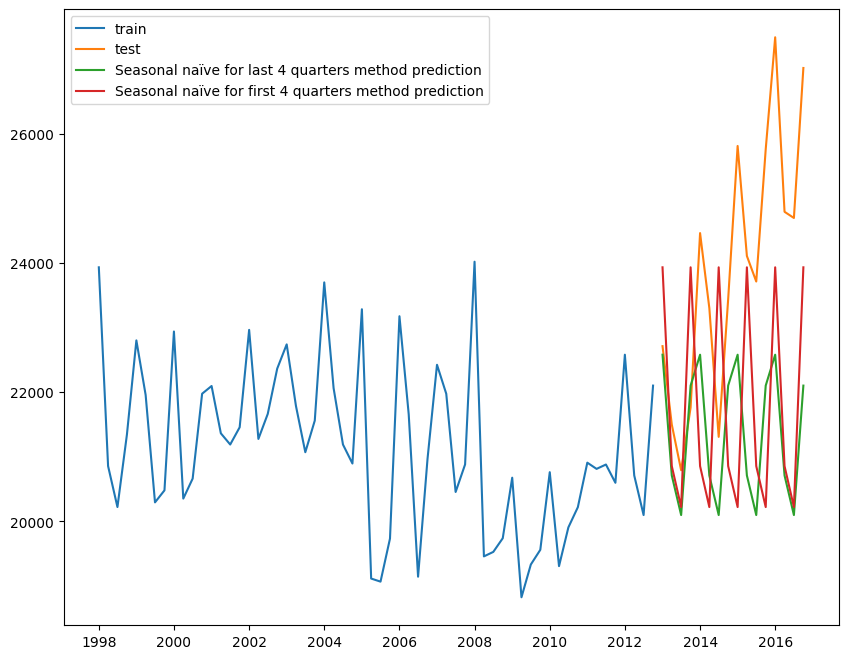

In [107]:
# repeat the last 4 quarters of the training data throughout the prediction series
pred_last4 = test.copy()
period = 4
for i in range(len(test)):
    pred_last4.iloc[i] = train.iloc[-period]
    period -= 1
    if period == 0:
        period = 4
# repeat the first quarter of the training data throughout the prediction series
pred_first4 = test.copy()
period = 4
h = 4
for i in range(len(test)):
    pred_first4.iloc[i] = train.iloc[period - h]
    h -= 1
    if h == 1:
        h = 4

plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(pred_last4, label="Seasonal naïve for last 4 quarters method prediction")
plt.plot(pred_first4, label="Seasonal naïve for first 4 quarters method prediction")
plt.legend(loc="best")
plt.show()

# works better for quarterly, annual, monthly data or data that usually have some seasonality to it

# Drift method: 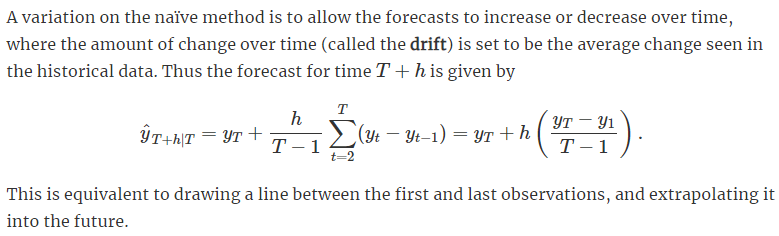

In [108]:
def parse(x):
    return datetime.strptime(x, "%Y-%m-%d")


df = pd.read_csv("./data/FB.csv", parse_dates=["Date"], date_parser=parse)
df = df[["Date", "Close"]].set_index("Date")
df

,Close
Date,
2012-07-09,31.730000
2012-07-10,32.169998
2012-07-11,31.469999
2012-07-12,30.969999
2012-07-13,30.809999
...,...
2018-11-21,132.429993
2018-11-23,134.820007
2018-11-26,131.729996


In [109]:
# 80:20 split
train = df[: int(len(df) * 0.8)]
print(train.tail())
test = df[int(len(df) * 0.8) :]
print(test.head())
print(len(train), len(test))

                 Close
Date                  
2017-08-14  168.080002
2017-08-15  170.750000
2017-08-16  171.000000
2017-08-17  170.000000
2017-08-18  166.910004
                 Close
Date                  
2017-08-21  167.410004
2017-08-22  167.779999
2017-08-23  169.639999
2017-08-24  168.710007
2017-08-25  167.740005
1286 322


ljungbox test for mean:
        lb_stat      lb_pvalue      bp_stat      bp_pvalue
1    297.869980   9.590392e-67   295.111925   3.826019e-66
2    572.313876  5.292013e-125   566.167624  1.143569e-123
3    824.381012  2.230837e-178   814.344835  3.350753e-176
4   1055.216499  3.852854e-227  1040.905591  4.868977e-224
5   1265.791466  1.645381e-271  1246.931099  2.004376e-267
6   1460.006996   0.000000e+00  1436.351183  3.257948e-307
7   1639.940088   0.000000e+00  1611.286135   0.000000e+00
8   1808.959941   0.000000e+00  1775.089325   0.000000e+00
9   1968.424814   0.000000e+00  1929.140267   0.000000e+00
10  2119.728394   0.000000e+00  2074.840011   0.000000e+00
ljungbox test for Naïve method:
        lb_stat      lb_pvalue      bp_stat      bp_pvalue
1    297.869980   9.590392e-67   295.111925   3.826019e-66
2    572.313876  5.292013e-125   566.167624  1.143569e-123
3    824.381012  2.230837e-178   814.344835  3.350753e-176
4   1055.216499  3.852854e-227  1040.905591  4.868977e-224


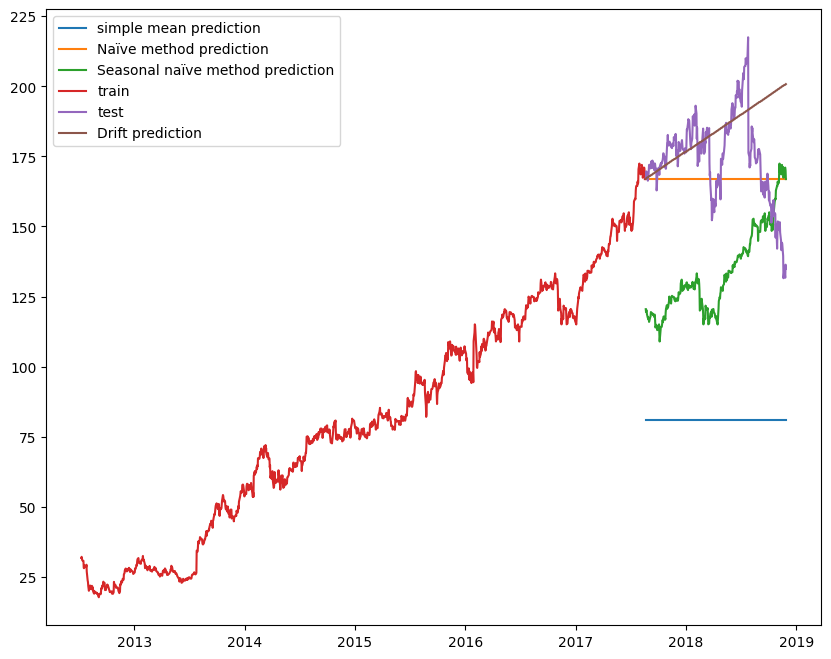

In [110]:
pred = test.copy()
pred[:] = train.mean()
resid = test - pred
if 10 <= len(train) / 5:
    l = 10
else:
    l = len(train) / 5
print(f"ljungbox test for mean:\n{ljungbox(resid, boxpierce=True, lags=l)}")
plt.plot(pred, label="simple mean prediction")
pred = test.copy()
pred[:] = train.iloc[-1]
resid = test - pred
print(f"ljungbox test for Naïve method:\n{ljungbox(resid, boxpierce=True, lags=l)}")
plt.plot(pred, label="Naïve method prediction")
pred = np.repeat(train.iloc[-322:], 1, axis=0)
pred = pd.DataFrame(pred, index=test.index, columns=["Close"])
resid = test - pred
print(
    f"ljungbox test for Seasonal naïve method:\n{ljungbox(resid, boxpierce=True, lags=l)}"
)
plt.plot(pred, label="Seasonal naïve method prediction")
T = len(train)
Yt = train.iloc[-1].values[0]
y1 = train.iloc[0].values[0]

print(f"slope: {(Yt - y1) / (T - 1)}")


def drift(y1, Yt, T, h):
    return Yt + (h * ((Yt - y1) / (T - 1)))


pred = test.copy()
for i in range(len(test)):
    pred.iloc[i] = drift(y1, Yt, T, i + 1)

resid = test - pred
print(f"ljungbox test for Drift method:\n{ljungbox(resid, boxpierce=True, lags=l)}")
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.plot(pred, label="Drift prediction")
plt.legend(loc="best")
plt.show()

# drawing the prediction interval for the drift method
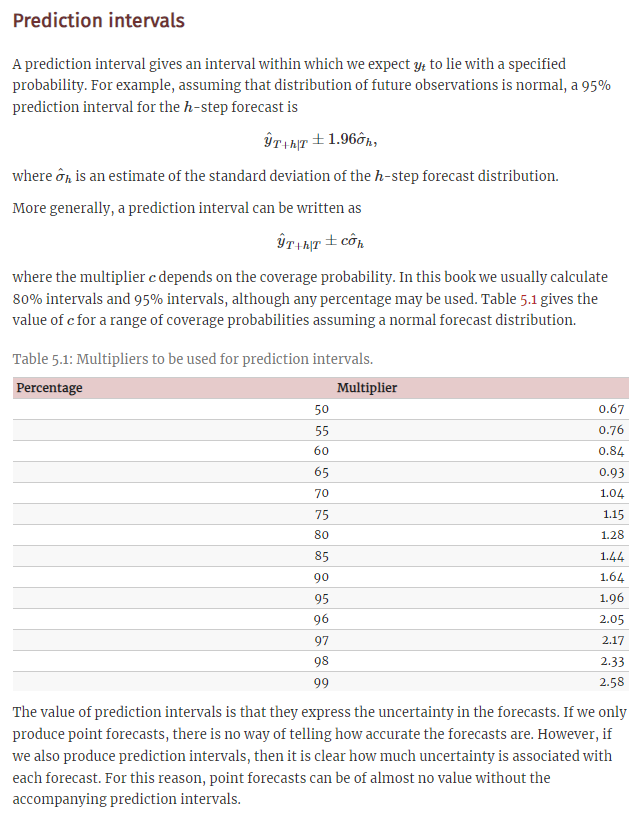
# One-step prediction intervals:
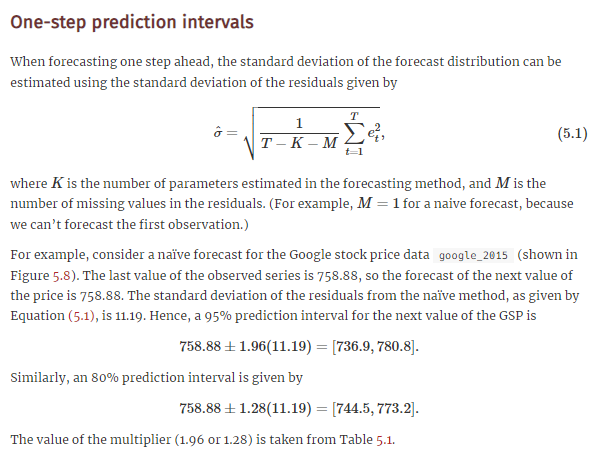
# Multi-step prediction intervals
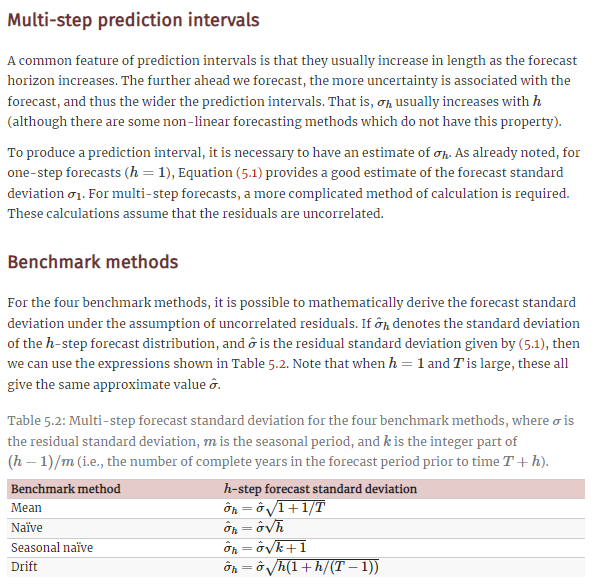

In [111]:
multiplier_95_percent = 1.96
multiplier_80_percent = 1.64

T = len(train)
K = len(test)
M = 0
Yt = train.iloc[-1].values[0]
y1 = train.iloc[0].values[0]

print(f"slope: {(Yt - y1) / (T - 1)}")


def drift(y1, Yt, T, h):
    return Yt + (h * ((Yt - y1) / (T - 1)))


pred_train = train.copy()
for i in range(len(train)):
    pred_train.iloc[i] = drift(y1, Yt, T, (i + 1) - len(train))

resid_train = train - pred_train


std_hat = sqrt((1 / (T - K - M)) * np.sum(resid_train**2))
print(f"std_hat: {std_hat}")

test["upper_95%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            + ((multiplier_95_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["upper_80%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            + ((multiplier_80_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["lower_95%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            - ((multiplier_95_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["lower_80%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            - ((multiplier_80_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["pred"] = drift(y1, Yt, T, range(1, len(test) + 1))
test

slope: 0.105198446692607
std_hat: 22.67555357180827


,Close,upper_95%,upper_80%,lower_95%,lower_80%,pred
Date,,,,,,
2017-08-21,167.410004,168.768588,168.482321,165.261817,165.548084,167.015202
2017-08-22,167.779999,170.157354,169.661525,164.083448,164.579277,167.120401
2017-08-23,169.639999,171.520499,170.819291,162.930700,163.631908,167.225599
2017-08-24,168.710007,172.875489,171.970234,161.786106,162.691362,167.330798
2017-08-25,167.740005,174.226829,173.118122,160.645164,161.753871,167.435996
...,...,...,...,...,...,...
2018-11-21,132.429993,595.248719,530.777600,-194.522499,-130.051379,200.363110
2018-11-23,134.820007,596.593750,531.920209,-195.657133,-130.983592,200.468308
2018-11-26,131.729996,597.938781,533.062818,-196.791767,-131.915804,200.573507


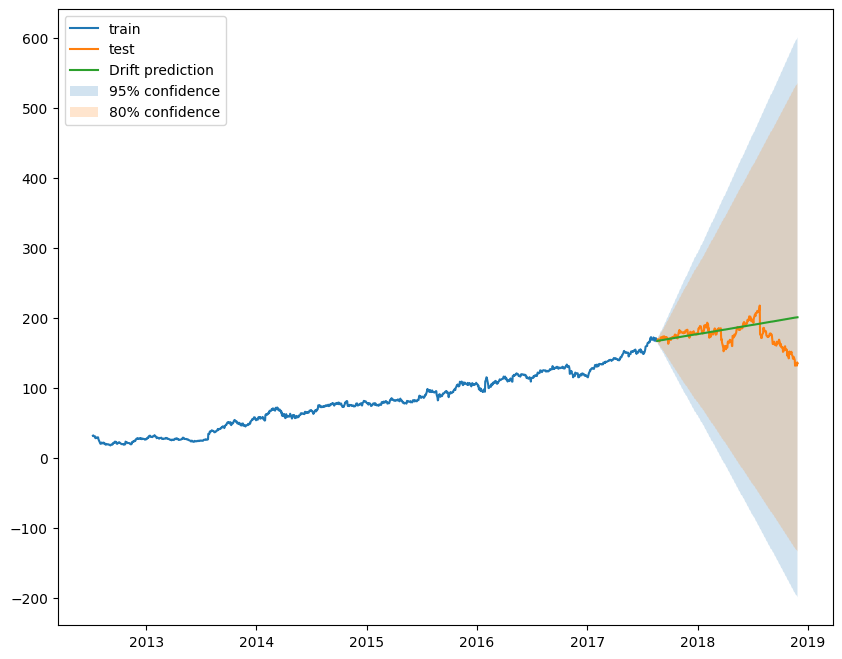

In [112]:
plt.plot(train, label="train")
plt.plot(test.Close, label="test")
plt.plot(test.pred, label="Drift prediction")
plt.fill_between(
    test.Close.index,
    test["lower_95%"],
    test["upper_95%"],
    alpha=0.2,
    label="95% confidence",
)
plt.fill_between(
    test.Close.index,
    test["lower_80%"],
    test["upper_80%"],
    alpha=0.2,
    label="80% confidence",
)
plt.legend(loc="best")
plt.show()

# applying the boxcox transformation on the Quarterly Australian Gas Production data

In [123]:
df = pd.read_csv(
    "./data/Quarterly_Australian_Gas_Production_777_37.csv",
)
df.drop(["Unnamed: 0", "X"], axis=1, inplace=True)


def parse_date(date):
    strDate = str(date)
    # return a datetime object
    if strDate[-2:] == ".0":
        strDate = strDate[:-2] + ".01"
        return pd.to_datetime(strDate, format="%Y.%m")
    elif strDate[-2:] == "25":
        strDate = strDate[:-2] + "04"
        return pd.to_datetime(strDate, format="%Y.%m")
    elif strDate[-2:] == ".5":
        strDate = strDate[:-2] + ".07"
        return pd.to_datetime(strDate, format="%Y.%m")
    elif strDate[-2:] == "75":
        strDate = strDate[:-2] + "10"
        return pd.to_datetime(strDate, format="%Y.%m")


df["Date"] = df["time"].apply(parse_date)
df.drop(["time"], axis=1, inplace=True)
df.set_index("Date", inplace=True)
df

,value
Date,
1956-01-01,5.149
1956-04-01,6.372
1956-07-01,7.068
1956-10-01,5.908
1957-01-01,5.359
...,...
2009-04-01,238.000
2009-07-01,252.000
2009-10-01,210.000


In [124]:
def plot_function(lambda_fixed):
    transformer = BoxCoxTransformer(method="fixed", lambda_fixed=lambda_fixed)
    BoxCox_y_hat = transformer.fit_transform(df)
    plt.plot(BoxCox_y_hat, label="BoxCox at lambda = " + str(lambda_fixed))
    plt.legend()
    plt.show()


plt.show()
# Create the interactive widget with a wider slider range
lambda_slider = widgets.FloatSlider(
    value=0.11,
    min=-5.0,
    max=5.0,
    step=0.01,
    description="Lambda:",
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="100%"),  # Adjust the width as needed
)

# Create the interactive widget
interact(plot_function, lambda_fixed=lambda_slider)

interactive(children=(FloatSlider(value=0.11, description='Lambda:', layout=Layout(width='100%'), max=5.0, min…

<function __main__.plot_function(lambda_fixed)>

## Forecasting using transformations:
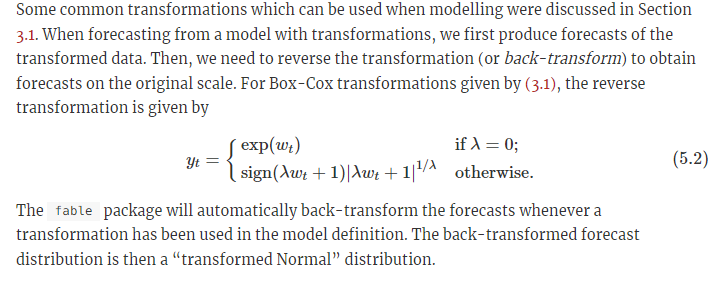 
## Prediction intervals with transformations and Bias adjustments:
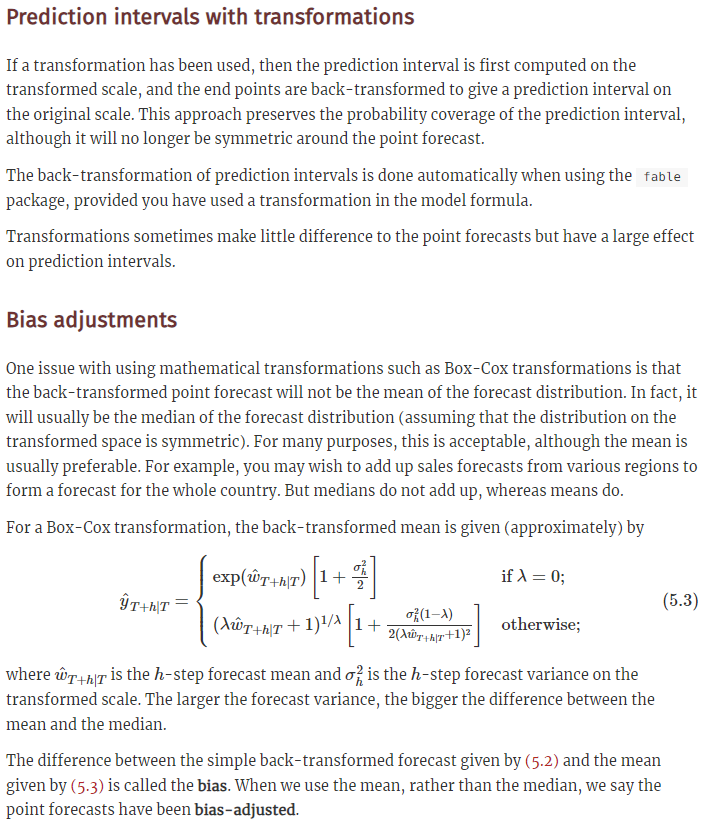
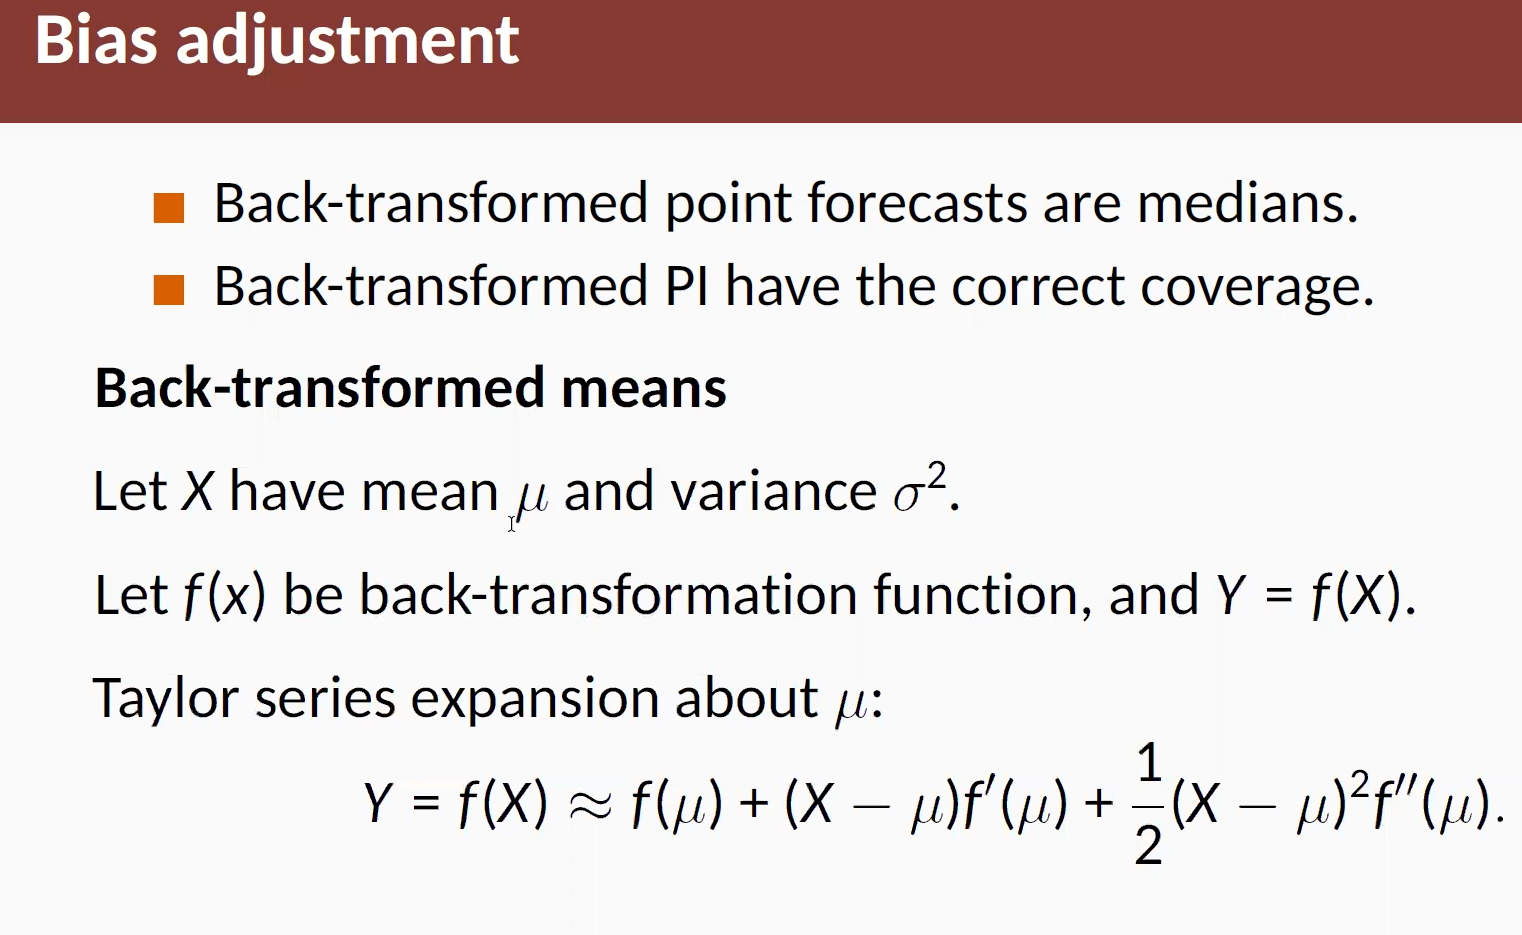

174 44
W_slope: 0.030218055833229285


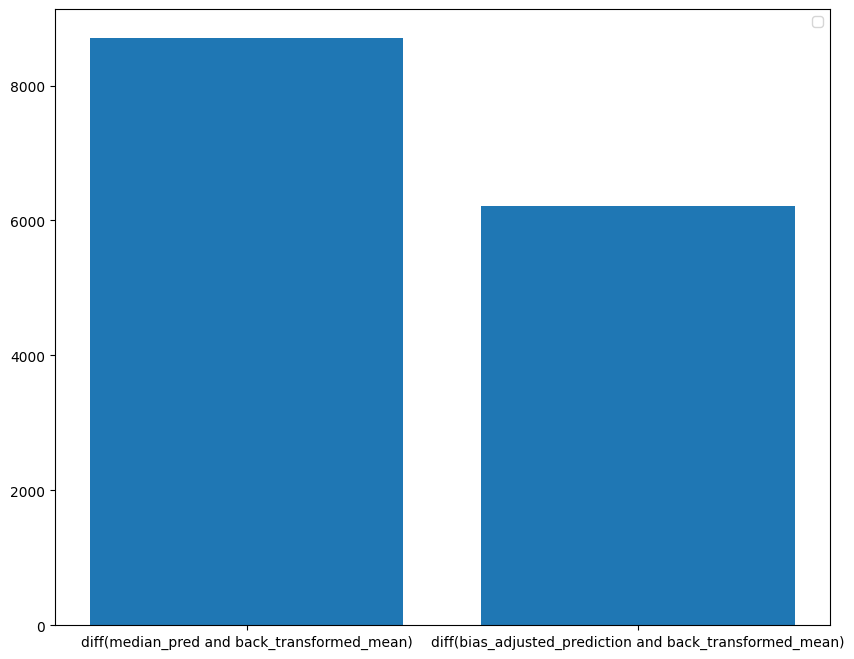

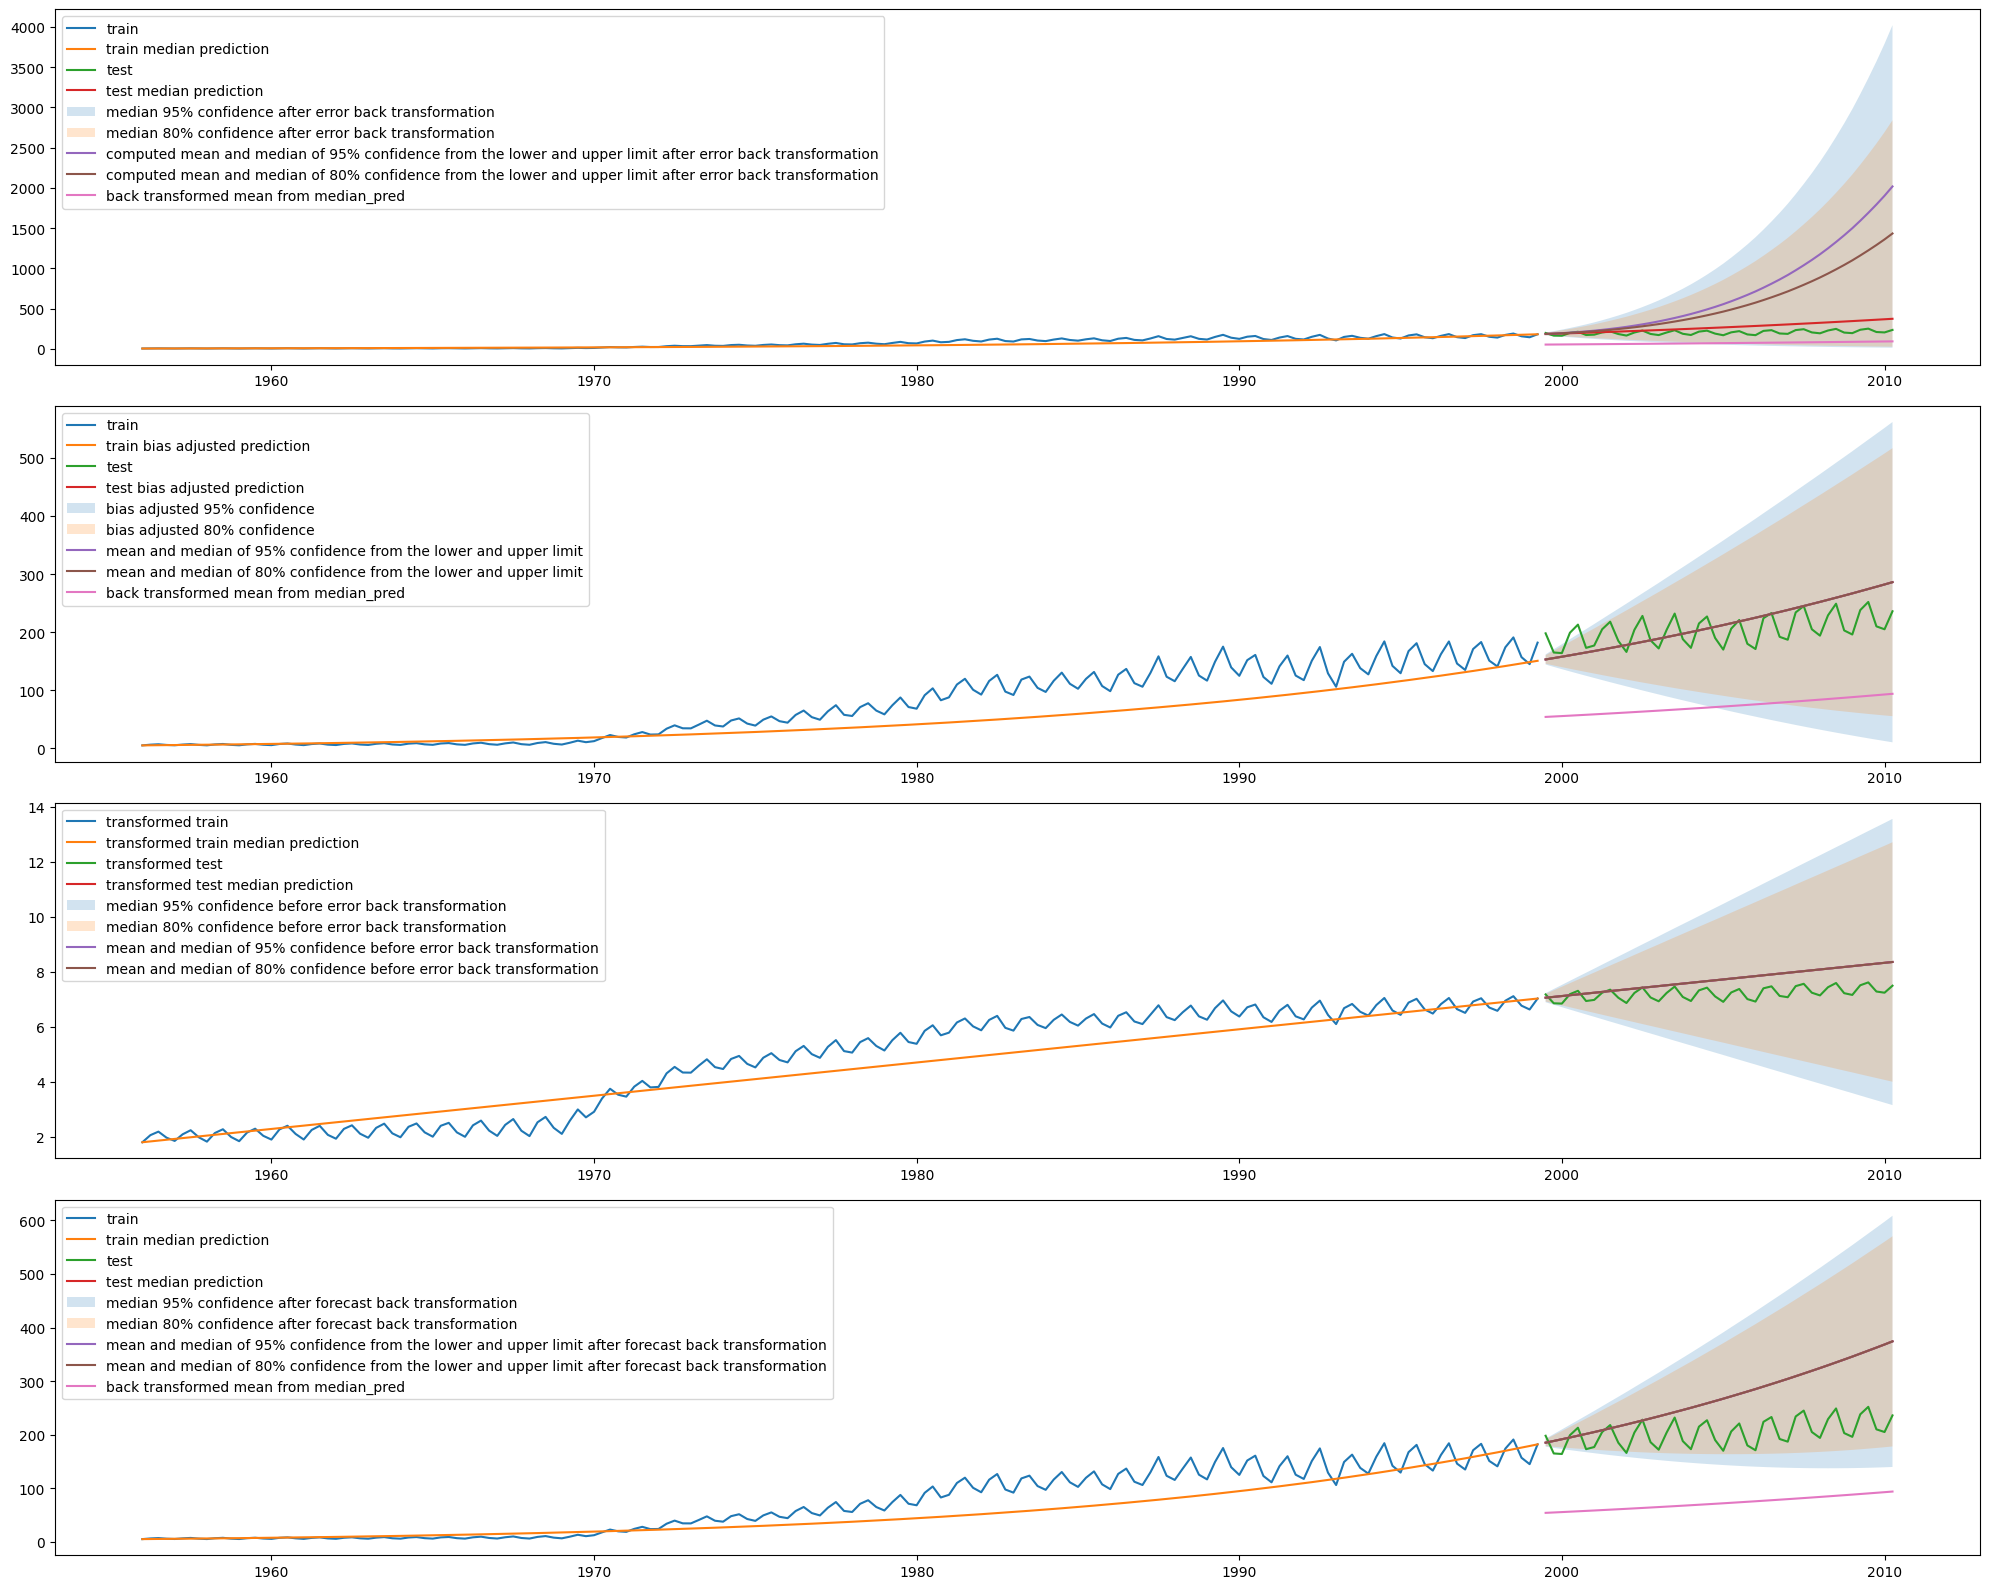

In [125]:
multiplier_95_percent = 1.96
multiplier_80_percent = 1.64
# BoxCox
lambda_fixed = 0.11
transformer = BoxCoxTransformer(
    method="fixed", lambda_fixed=lambda_fixed, enforce_positive=False
)
W = transformer.fit_transform(df)

# 80:20 split
W_train, W_test = W[: int(len(W) * 0.8)], W[int(len(W) * 0.8) :]
train, test = df[: int(len(df) * 0.8)], df[int(len(df) * 0.8) :]
print(len(W_train), len(W_test))


# Drift prediction
T = len(W_train)
K = len(W_test)
M = 0
Yt = W_train.iloc[-1].values[0]
y1 = W_train.iloc[0].values[0]
print(f"W_slope: {(Yt - y1) / (T - 1)}")


def drift(y1, Yt, T, h):
    return Yt + (h * ((Yt - y1) / (T - 1)))


def bias_adjusted_prediction(Mu, w):
    if lambda_fixed == 0:
        f = lambda x: jnp.exp(x)
        fd = grad(f)
        fdd = grad(grad(f))
    else:
        f = lambda x: jnp.sign((lambda_fixed * x) + 1) * (
            jnp.abs((lambda_fixed * x) + 1) ** (1 / lambda_fixed)
        )
        fd = grad(f)
        fdd = grad(grad(f))
    return f(Mu) + ((w - Mu) * fd(Mu)) + (0.5 * ((w - Mu) ** 2) * fdd(Mu))


def back_transformed_mean(h_mean, h_var):
    if lambda_fixed == 0:
        return exp(h_mean) * (1 + (h_var / 2))
    else:
        return ((lambda_fixed * h_mean + 1) ** (1 / lambda_fixed)) * (
            1
            + ((h_var * (1 - lambda_fixed)) / (2 * ((lambda_fixed * h_mean + 1) ** 2)))
        )


median_pred = W_test.copy()
for i in range(len(W_test)):
    median_pred.iloc[i] = drift(y1, Yt, T, (i + 1))
W_test["median_pred"] = median_pred
median_pred = transformer.inverse_transform(median_pred)
test["median_pred"] = median_pred

median_pred_train = W_train.copy()
for i in range(len(W_train)):
    median_pred_train.iloc[i] = drift(y1, Yt, T, (i + 1) - len(W_train))
W_train["median_pred"] = median_pred_train
median_pred_train = transformer.inverse_transform(median_pred_train)
train["median_pred"] = median_pred_train

median_resid_train = train["value"] - train["median_pred"]
std_hat_median = sqrt((1 / (T - K - M)) * np.sum(median_resid_train**2))
test["median_pred_upper_95%_after_forecast_back_transformation"] = test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_95_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_upper_80%_after_forecast_back_transformation"] = test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_80_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_lower_95%_after_forecast_back_transformation"] = test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_95_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_lower_80%_after_forecast_back_transformation"] = test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_80_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)

w_median_resid_train = W_train["value"] - W_train["median_pred"]
w_std_hat_median = sqrt((1 / (T - K - M)) * np.sum(w_median_resid_train**2))
W_test["median_pred_upper_95%_before_error_back_transformation"] = W_test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_95_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_upper_80%_before_error_back_transformation"] = W_test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_80_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_lower_95%_before_error_back_transformation"] = W_test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_95_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_lower_80%_before_error_back_transformation"] = W_test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_80_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)

test["median_pred_upper_95%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_upper_95%_before_error_back_transformation"]
    )
)
test["median_pred_upper_80%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_upper_80%_before_error_back_transformation"]
    )
)
test["median_pred_lower_95%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_lower_95%_before_error_back_transformation"]
    )
)
test["median_pred_lower_80%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_lower_80%_before_error_back_transformation"]
    )
)

test["back_transformed_mean_from_median_pred"] = pd.Series(index=test.index)
j = 0
for i in range(len(train), len(train) + len(test)):
    if i == len(train) + len(test) - 1:
        test["back_transformed_mean_from_median_pred"].iloc[j] = back_transformed_mean(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).var(
                axis=0
            ),
        )
    else:
        test["back_transformed_mean_from_median_pred"].iloc[j] = back_transformed_mean(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .var(axis=0),
        )
    j += 1

train["bias_adjusted_prediction"] = pd.Series(index=train.index)
j = 0
for i in range(len(train)):
    if i == len(train) - 1:
        train["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            W_train["median_pred"].mean(),
            W_train["median_pred"].iloc[-1],
        )
    else:
        train["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            W_train["median_pred"].iloc[: i + 1].mean(),
            W_train["median_pred"].iloc[i],
        )
    j += 1

test["bias_adjusted_prediction"] = pd.Series(index=test.index)
j = 0
for i in range(len(train), len(train) + len(test)):
    if i == len(train) + len(test) - 1:
        test["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).iloc[-1],
        )
    else:
        test["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).iloc[i],
        )
    j += 1

bias_adjusted_resid_train = train["value"] - train["bias_adjusted_prediction"]
std_hat_bias_adjusted = sqrt((1 / (T - K - M)) * np.sum(bias_adjusted_resid_train**2))
test["bias_adjusted_pred_upper_95%"] = test["bias_adjusted_prediction"] + pd.Series(
    (
        [
            (
                (multiplier_95_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_upper_80%"] = test["bias_adjusted_prediction"] + pd.Series(
    (
        [
            (
                (multiplier_80_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_lower_95%"] = test["bias_adjusted_prediction"] - pd.Series(
    (
        [
            (
                (multiplier_95_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_lower_80%"] = test["bias_adjusted_prediction"] - pd.Series(
    (
        [
            (
                (multiplier_80_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)

plt.bar(
    [
        "diff(median_pred and back_transformed_mean)",
        "diff(bias_adjusted_prediction and back_transformed_mean)",
    ],
    [
        (test["median_pred"] - test["back_transformed_mean_from_median_pred"]).sum(),
        (
            test["bias_adjusted_prediction"]
            - test["back_transformed_mean_from_median_pred"]
        ).sum(),
    ],
)
plt.legend()
plt.show()

# Create a figure and a gridspec layout
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 1)
# Add subplots to the layout
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax1.plot(train["value"], label="train")
ax1.plot(train["median_pred"], label="train median prediction")
ax1.plot(test["value"], label="test")
ax1.plot(test["median_pred"], label="test median prediction")
ax1.fill_between(
    test["value"].index,
    test["median_pred_lower_95%_after_error_back_transformation"],
    test["median_pred_upper_95%_after_error_back_transformation"],
    alpha=0.2,
    label="median 95% confidence after error back transformation",
)
ax1.fill_between(
    test["value"].index,
    test["median_pred_lower_80%_after_error_back_transformation"],
    test["median_pred_upper_80%_after_error_back_transformation"],
    alpha=0.2,
    label="median 80% confidence after error back transformation",
)
ax1.plot(
    (
        test["median_pred_lower_95%_after_error_back_transformation"]
        + test["median_pred_upper_95%_after_error_back_transformation"]
    )
    / 2,
    label="computed mean and median of 95% confidence from the lower and upper limit after error back transformation",
)
ax1.plot(
    (
        test["median_pred_lower_80%_after_error_back_transformation"]
        + test["median_pred_upper_80%_after_error_back_transformation"]
    )
    / 2,
    label="computed mean and median of 80% confidence from the lower and upper limit after error back transformation",
)
ax1.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax1.legend(loc="best")

ax2.plot(train["value"], label="train")
ax2.plot(train["bias_adjusted_prediction"], label="train bias adjusted prediction")
ax2.plot(test["value"], label="test")
ax2.plot(test["bias_adjusted_prediction"], label="test bias adjusted prediction")
ax2.fill_between(
    test["value"].index,
    test["bias_adjusted_pred_lower_95%"],
    test["bias_adjusted_pred_upper_95%"],
    alpha=0.2,
    label="bias adjusted 95% confidence",
)
ax2.fill_between(
    test["value"].index,
    test["bias_adjusted_pred_lower_80%"],
    test["bias_adjusted_pred_upper_80%"],
    alpha=0.2,
    label="bias adjusted 80% confidence",
)
ax2.plot(
    (test["bias_adjusted_pred_lower_95%"] + test["bias_adjusted_pred_upper_95%"]) / 2,
    label="mean and median of 95% confidence from the lower and upper limit",
)
ax2.plot(
    (test["bias_adjusted_pred_lower_80%"] + test["bias_adjusted_pred_upper_80%"]) / 2,
    label="mean and median of 80% confidence from the lower and upper limit",
)
ax2.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax2.legend(loc="best")

ax3.plot(W_train["value"], label="transformed train")
ax3.plot(W_train["median_pred"], label="transformed train median prediction")
ax3.plot(W_test["value"], label="transformed test")
ax3.plot(W_test["median_pred"], label="transformed test median prediction")
ax3.fill_between(
    W_test.index,
    W_test["median_pred_lower_95%_before_error_back_transformation"],
    W_test["median_pred_upper_95%_before_error_back_transformation"],
    alpha=0.2,
    label="median 95% confidence before error back transformation",
)
ax3.fill_between(
    W_test.index,
    W_test["median_pred_lower_80%_before_error_back_transformation"],
    W_test["median_pred_upper_80%_before_error_back_transformation"],
    alpha=0.2,
    label="median 80% confidence before error back transformation",
)
ax3.plot(
    (
        W_test["median_pred_lower_95%_before_error_back_transformation"]
        + W_test["median_pred_upper_95%_before_error_back_transformation"]
    )
    / 2,
    label="mean and median of 95% confidence before error back transformation",
)
ax3.plot(
    (
        W_test["median_pred_lower_80%_before_error_back_transformation"]
        + W_test["median_pred_upper_80%_before_error_back_transformation"]
    )
    / 2,
    label="mean and median of 80% confidence before error back transformation",
)
ax3.legend(loc="best")

ax4.plot(train["value"], label="train")
ax4.plot(train["median_pred"], label="train median prediction")
ax4.plot(test["value"], label="test")
ax4.plot(test["median_pred"], label="test median prediction")
ax4.fill_between(
    test["value"].index,
    test["median_pred_lower_95%_after_forecast_back_transformation"],
    test["median_pred_upper_95%_after_forecast_back_transformation"],
    alpha=0.2,
    label="median 95% confidence after forecast back transformation",
)
ax4.fill_between(
    test["value"].index,
    test["median_pred_lower_80%_after_forecast_back_transformation"],
    test["median_pred_upper_80%_after_forecast_back_transformation"],
    alpha=0.2,
    label="median 80% confidence after forecast back transformation",
)
ax4.plot(
    (
        test["median_pred_lower_95%_after_forecast_back_transformation"]
        + test["median_pred_upper_95%_after_forecast_back_transformation"]
    )
    / 2,
    label="mean and median of 95% confidence from the lower and upper limit after forecast back transformation",
)
ax4.plot(
    (
        test["median_pred_lower_80%_after_forecast_back_transformation"]
        + test["median_pred_upper_80%_after_forecast_back_transformation"]
    )
    / 2,
    label="mean and median of 80% confidence from the lower and upper limit after forecast back transformation",
)
ax4.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax4.legend(loc="best")
plt.tight_layout()
plt.show()

In [148]:
def parse(x):
    return datetime.strptime(x, "%Y-%m-%d")


df = pd.read_csv("./data/tourism.csv", parse_dates=["Quarter"], date_parser=parse)
df.drop(["Unnamed: 0", "Region", "State", "Purpose"], axis=1, inplace=True)
df = df.groupby("Quarter").sum().reset_index().set_index("Quarter")
df.sort_index(inplace=True)
df

,Trips
Quarter,
1998-01-01,23932.544141
1998-04-01,20856.726540
1998-07-01,20222.802189
1998-10-01,21342.960517
1999-01-01,22801.711403
...,...
2015-10-01,25759.429177
2016-01-01,27492.360374
2016-04-01,24791.797758


In [149]:
def plot_function(lambda_fixed):
    transformer = BoxCoxTransformer(method="fixed", lambda_fixed=lambda_fixed)
    BoxCox_y_hat = transformer.fit_transform(df)
    plt.plot(BoxCox_y_hat, label="BoxCox at lambda = " + str(lambda_fixed))
    plt.legend()
    plt.show()


plt.show()
# Create the interactive widget with a wider slider range
lambda_slider = widgets.FloatSlider(
    value=-3.16,
    min=-30.0,
    max=30.0,
    step=0.01,
    description="Lambda:",
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="100%"),  # Adjust the width as needed
)

# Create the interactive widget
interact(plot_function, lambda_fixed=lambda_slider)

interactive(children=(FloatSlider(value=-3.16, description='Lambda:', layout=Layout(width='100%'), max=30.0, m…

<function __main__.plot_function(lambda_fixed)>

60 16
W_slope: -2.163994031049034e-17
Quarter
2013-01-01   NaN
2013-04-01   NaN
2013-07-01   NaN
2013-10-01   NaN
2014-01-01   NaN
2014-04-01   NaN
2014-07-01   NaN
2014-10-01   NaN
2015-01-01   NaN
2015-04-01   NaN
2015-07-01   NaN
2015-10-01   NaN
2016-01-01   NaN
2016-04-01   NaN
2016-07-01   NaN
2016-10-01   NaN
Name: bias_adjusted_prediction, dtype: float64
Quarter
1998-01-01   NaN
1998-04-01   NaN
1998-07-01   NaN
1998-10-01   NaN
1999-01-01   NaN
1999-04-01   NaN
1999-07-01   NaN
1999-10-01   NaN
2000-01-01   NaN
2000-04-01   NaN
2000-07-01   NaN
2000-10-01   NaN
2001-01-01   NaN
2001-04-01   NaN
2001-07-01   NaN
2001-10-01   NaN
2002-01-01   NaN
2002-04-01   NaN
2002-07-01   NaN
2002-10-01   NaN
2003-01-01   NaN
2003-04-01   NaN
2003-07-01   NaN
2003-10-01   NaN
2004-01-01   NaN
2004-04-01   NaN
2004-07-01   NaN
2004-10-01   NaN
2005-01-01   NaN
2005-04-01   NaN
2005-07-01   NaN
2005-10-01   NaN
2006-01-01   NaN
2006-04-01   NaN
2006-07-01   NaN
2006-10-01   NaN
2007-01-01   Na

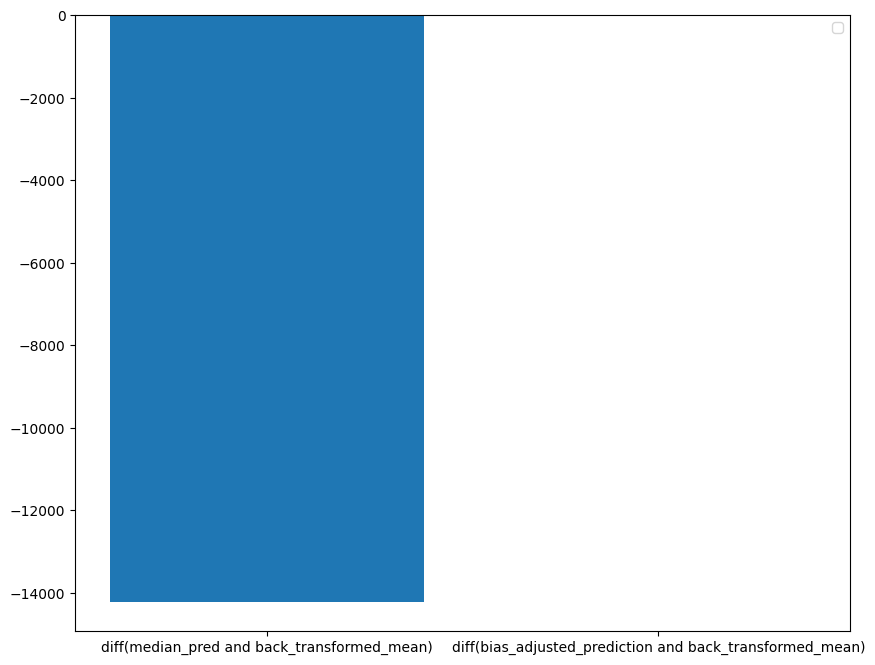

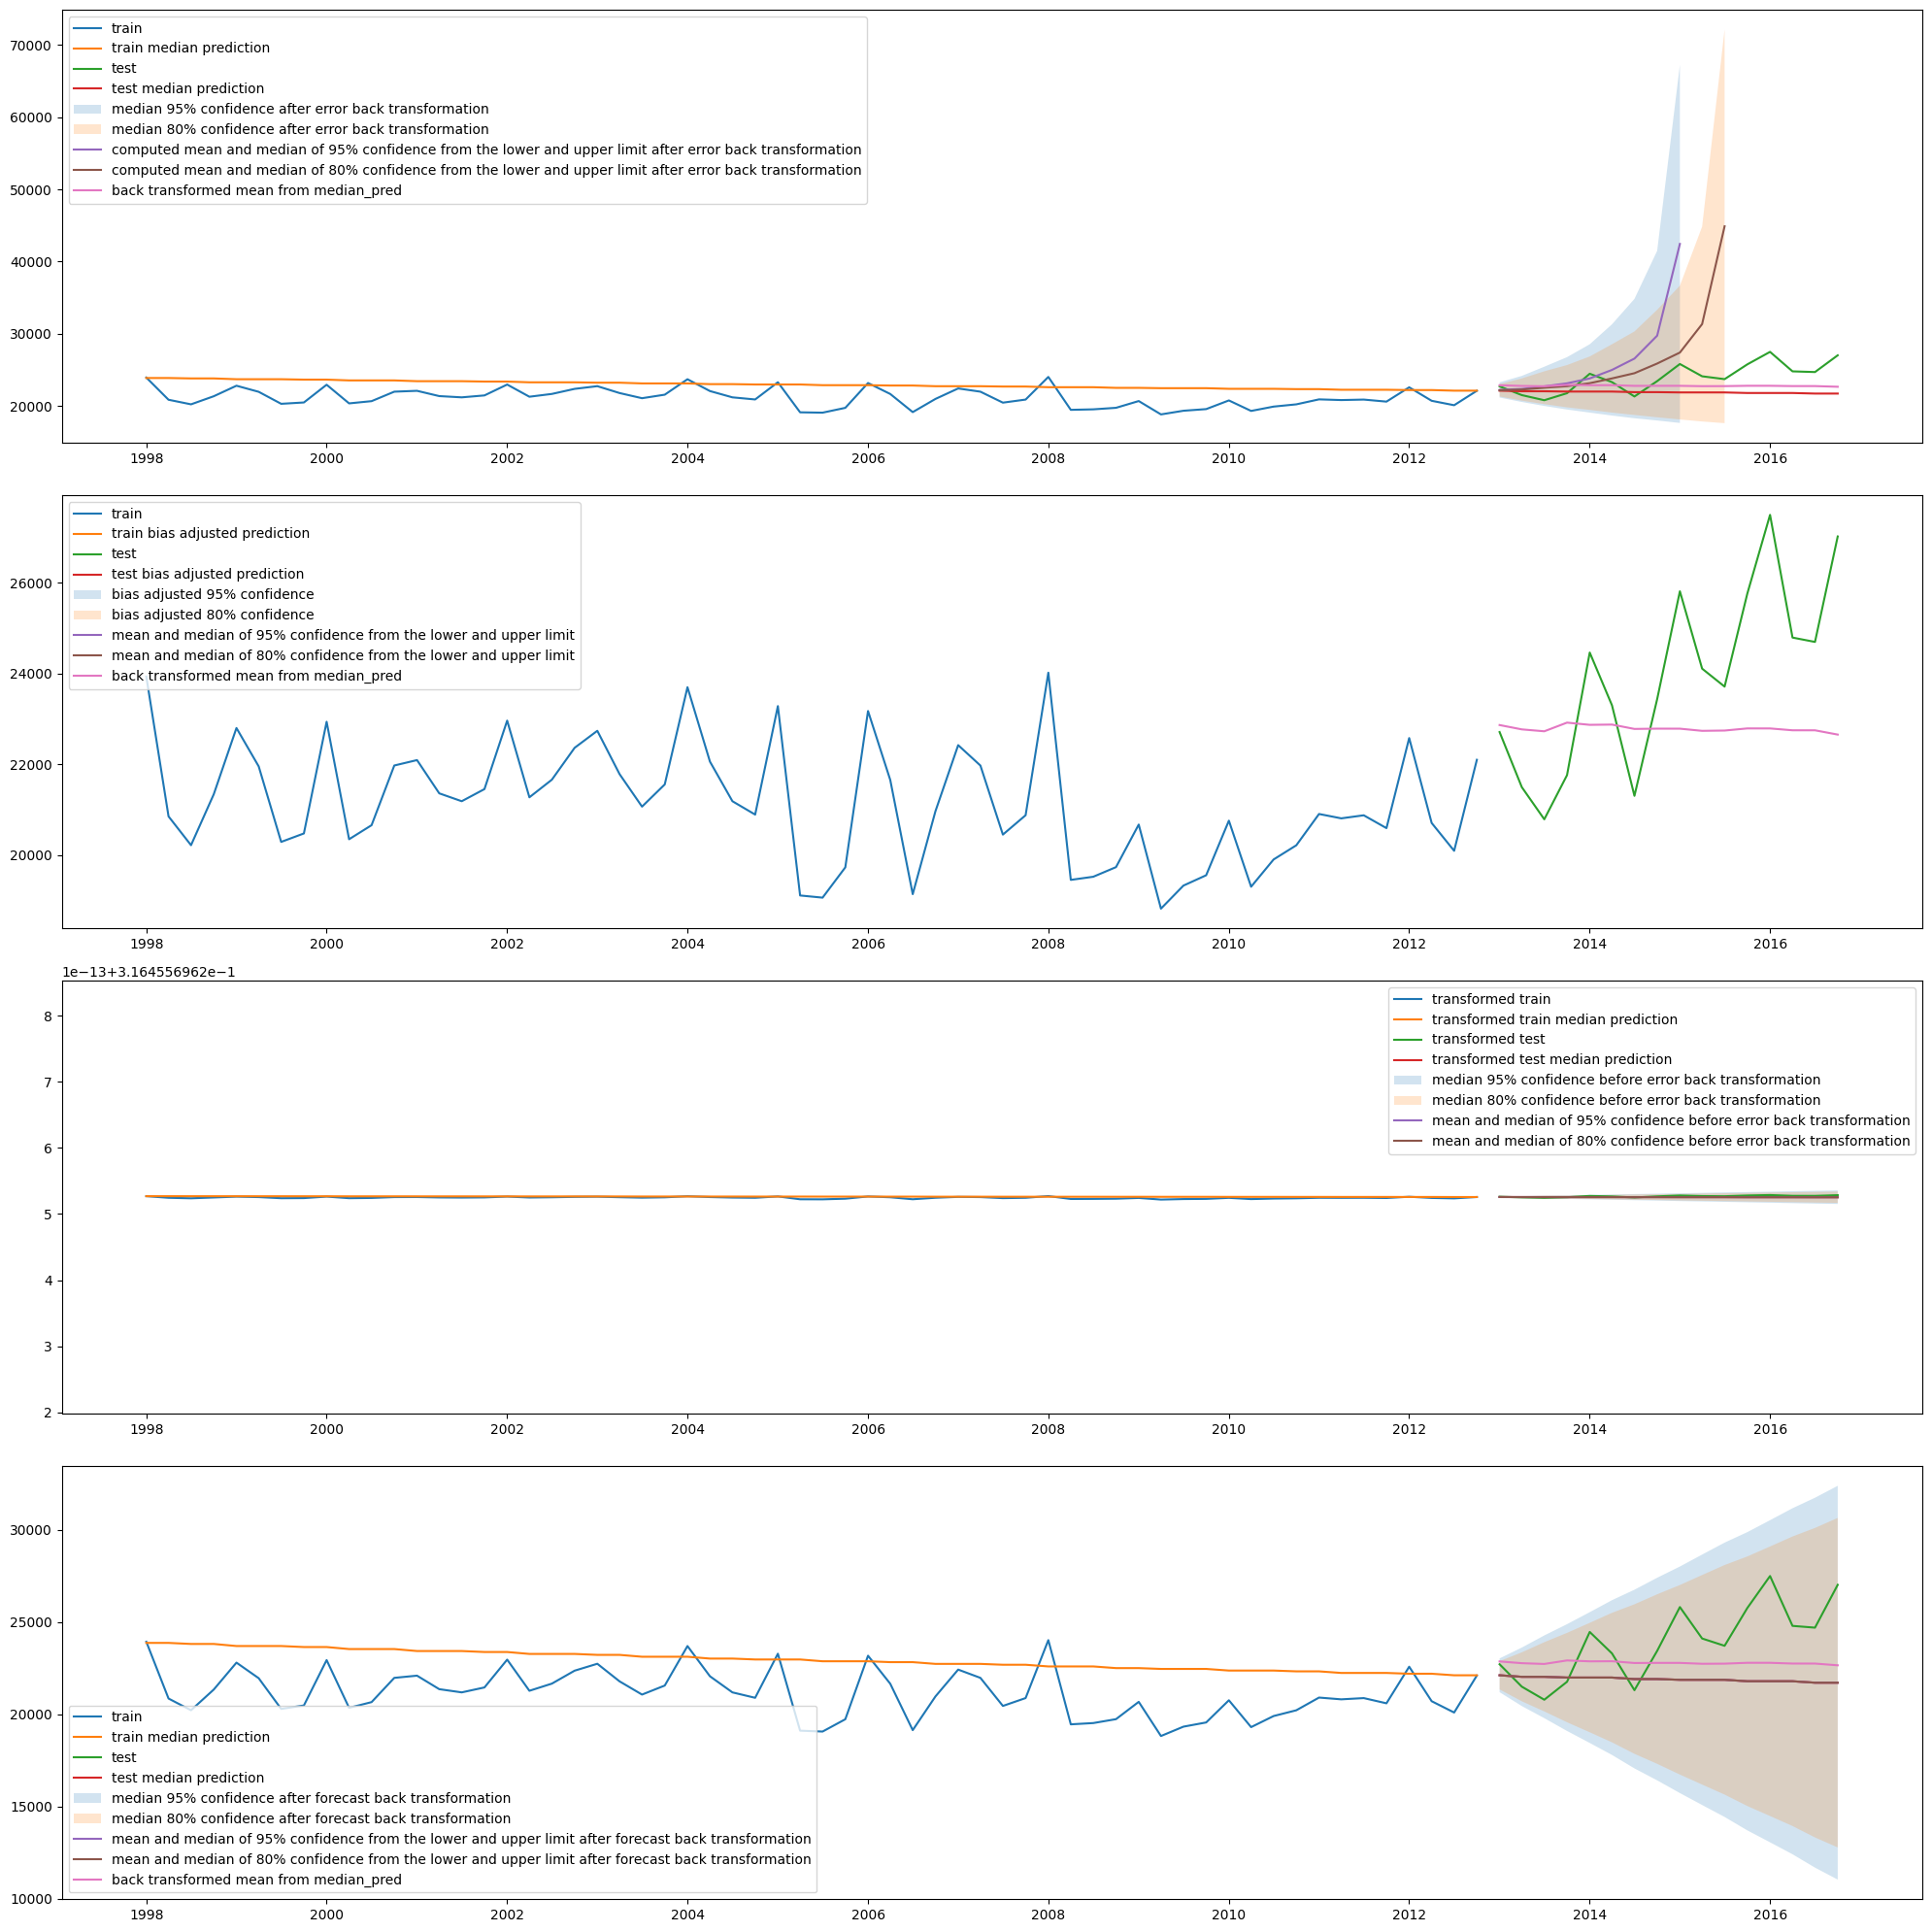

In [150]:
multiplier_95_percent = 1.96
multiplier_80_percent = 1.64
# BoxCox
lambda_fixed = -3.16
transformer = BoxCoxTransformer(
    method="fixed", lambda_fixed=lambda_fixed, enforce_positive=False
)
W = transformer.fit_transform(df)

# 80:20 split
W_train, W_test = W[: int(len(W) * 0.8)], W[int(len(W) * 0.8) :]
train, test = df[: int(len(df) * 0.8)], df[int(len(df) * 0.8) :]
print(len(W_train), len(W_test))


# Drift prediction
T = len(W_train)
K = len(W_test)
M = 0
Yt = W_train.iloc[-1].values[0]
y1 = W_train.iloc[0].values[0]
print(f"W_slope: {(Yt - y1) / (T - 1)}")


def drift(y1, Yt, T, h):
    return Yt + (h * ((Yt - y1) / (T - 1)))


def bias_adjusted_prediction(Mu, w):
    if lambda_fixed == 0:
        f = lambda x: jnp.exp(x)
        fd = grad(f)
        fdd = grad(grad(f))
    else:
        f = lambda x: jnp.sign((lambda_fixed * x) + 1) * (
            jnp.abs((lambda_fixed * x) + 1) ** (1 / lambda_fixed)
        )
        fd = grad(f)
        fdd = grad(grad(f))
    return f(Mu) + ((w - Mu) * fd(Mu)) + (0.5 * ((w - Mu) ** 2) * fdd(Mu))


def back_transformed_mean(h_mean, h_var):
    if lambda_fixed == 0:
        return exp(h_mean) * (1 + (h_var / 2))
    else:
        return ((lambda_fixed * h_mean + 1) ** (1 / lambda_fixed)) * (
            1
            + ((h_var * (1 - lambda_fixed)) / (2 * ((lambda_fixed * h_mean + 1) ** 2)))
        )


median_pred = W_test.copy()
for i in range(len(W_test)):
    median_pred.iloc[i] = drift(y1, Yt, T, (i + 1))
W_test["median_pred"] = median_pred
median_pred = transformer.inverse_transform(median_pred)
test["median_pred"] = median_pred

median_pred_train = W_train.copy()
for i in range(len(W_train)):
    median_pred_train.iloc[i] = drift(y1, Yt, T, (i + 1) - len(W_train))
W_train["median_pred"] = median_pred_train
median_pred_train = transformer.inverse_transform(median_pred_train)
train["median_pred"] = median_pred_train

median_resid_train = train["Trips"] - train["median_pred"]
std_hat_median = sqrt((1 / (T - K - M)) * np.sum(median_resid_train**2))
test["median_pred_upper_95%_after_forecast_back_transformation"] = test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_95_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_upper_80%_after_forecast_back_transformation"] = test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_80_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_lower_95%_after_forecast_back_transformation"] = test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_95_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["median_pred_lower_80%_after_forecast_back_transformation"] = test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_80_percent * std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)

w_median_resid_train = W_train["Trips"] - W_train["median_pred"]
w_std_hat_median = sqrt((1 / (T - K - M)) * np.sum(w_median_resid_train**2))
W_test["median_pred_upper_95%_before_error_back_transformation"] = W_test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_95_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_upper_80%_before_error_back_transformation"] = W_test[
    "median_pred"
] + pd.Series(
    (
        [
            ((multiplier_80_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_lower_95%_before_error_back_transformation"] = W_test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_95_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)
W_test["median_pred_lower_80%_before_error_back_transformation"] = W_test[
    "median_pred"
] - pd.Series(
    (
        [
            ((multiplier_80_percent * w_std_hat_median) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(W_test) + 1)
        ]
    ),
    index=W_test.index,
)

test["median_pred_upper_95%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_upper_95%_before_error_back_transformation"]
    )
)
test["median_pred_upper_80%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_upper_80%_before_error_back_transformation"]
    )
)
test["median_pred_lower_95%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_lower_95%_before_error_back_transformation"]
    )
)
test["median_pred_lower_80%_after_error_back_transformation"] = (
    transformer.inverse_transform(
        W_test["median_pred_lower_80%_before_error_back_transformation"]
    )
)

test["back_transformed_mean_from_median_pred"] = pd.Series(index=test.index)
j = 0
for i in range(len(train), len(train) + len(test)):
    if i == len(train) + len(test) - 1:
        test["back_transformed_mean_from_median_pred"].iloc[j] = back_transformed_mean(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).var(
                axis=0
            ),
        )
    else:
        test["back_transformed_mean_from_median_pred"].iloc[j] = back_transformed_mean(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .var(axis=0),
        )
    j += 1

train["bias_adjusted_prediction"] = pd.Series(index=train.index)
j = 0
for i in range(len(train)):
    if i == len(train) - 1:
        train["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            W_train["median_pred"].mean(),
            W_train["median_pred"].iloc[-1],
        )
    else:
        train["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            W_train["median_pred"].iloc[: i + 1].mean(),
            W_train["median_pred"].iloc[i],
        )
    j += 1

test["bias_adjusted_prediction"] = pd.Series(index=test.index)
j = 0
for i in range(len(train), len(train) + len(test)):
    if i == len(train) + len(test) - 1:
        test["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).iloc[-1],
        )
    else:
        test["bias_adjusted_prediction"].iloc[j] = bias_adjusted_prediction(
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0)
            .iloc[: i + 1]
            .mean(),
            pd.concat([W_train["median_pred"], W_test["median_pred"]], axis=0).iloc[i],
        )
    j += 1

print(test["bias_adjusted_prediction"])
print(train["bias_adjusted_prediction"])
bias_adjusted_resid_train = train["Trips"] - train["bias_adjusted_prediction"]
std_hat_bias_adjusted = sqrt((1 / (T - K - M)) * np.sum(bias_adjusted_resid_train**2))
test["bias_adjusted_pred_upper_95%"] = test["bias_adjusted_prediction"] + pd.Series(
    (
        [
            (
                (multiplier_95_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_upper_80%"] = test["bias_adjusted_prediction"] + pd.Series(
    (
        [
            (
                (multiplier_80_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_lower_95%"] = test["bias_adjusted_prediction"] - pd.Series(
    (
        [
            (
                (multiplier_95_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["bias_adjusted_pred_lower_80%"] = test["bias_adjusted_prediction"] - pd.Series(
    (
        [
            (
                (multiplier_80_percent * std_hat_bias_adjusted)
                * sqrt(h * ((1 + h) / (T - 1)))
            )
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)

plt.bar(
    [
        "diff(median_pred and back_transformed_mean)",
        "diff(bias_adjusted_prediction and back_transformed_mean)",
    ],
    [
        (test["median_pred"] - test["back_transformed_mean_from_median_pred"]).sum(),
        (
            test["bias_adjusted_prediction"]
            - test["back_transformed_mean_from_median_pred"]
        ).sum(),
    ],
)
plt.legend()
plt.show()

# Create a figure and a gridspec layout
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 1)
# Add subplots to the layout
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax1.plot(train["Trips"], label="train")
ax1.plot(train["median_pred"], label="train median prediction")
ax1.plot(test["Trips"], label="test")
ax1.plot(test["median_pred"], label="test median prediction")
ax1.fill_between(
    test["Trips"].index,
    test["median_pred_lower_95%_after_error_back_transformation"],
    test["median_pred_upper_95%_after_error_back_transformation"],
    alpha=0.2,
    label="median 95% confidence after error back transformation",
)
ax1.fill_between(
    test["Trips"].index,
    test["median_pred_lower_80%_after_error_back_transformation"],
    test["median_pred_upper_80%_after_error_back_transformation"],
    alpha=0.2,
    label="median 80% confidence after error back transformation",
)
ax1.plot(
    (
        test["median_pred_lower_95%_after_error_back_transformation"]
        + test["median_pred_upper_95%_after_error_back_transformation"]
    )
    / 2,
    label="computed mean and median of 95% confidence from the lower and upper limit after error back transformation",
)
ax1.plot(
    (
        test["median_pred_lower_80%_after_error_back_transformation"]
        + test["median_pred_upper_80%_after_error_back_transformation"]
    )
    / 2,
    label="computed mean and median of 80% confidence from the lower and upper limit after error back transformation",
)
ax1.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax1.legend(loc="best")

ax2.plot(train["Trips"], label="train")
ax2.plot(train["bias_adjusted_prediction"], label="train bias adjusted prediction")
ax2.plot(test["Trips"], label="test")
ax2.plot(test["bias_adjusted_prediction"], label="test bias adjusted prediction")
ax2.fill_between(
    test["Trips"].index,
    test["bias_adjusted_pred_lower_95%"],
    test["bias_adjusted_pred_upper_95%"],
    alpha=0.2,
    label="bias adjusted 95% confidence",
)
ax2.fill_between(
    test["Trips"].index,
    test["bias_adjusted_pred_lower_80%"],
    test["bias_adjusted_pred_upper_80%"],
    alpha=0.2,
    label="bias adjusted 80% confidence",
)
ax2.plot(
    (test["bias_adjusted_pred_lower_95%"] + test["bias_adjusted_pred_upper_95%"]) / 2,
    label="mean and median of 95% confidence from the lower and upper limit",
)
ax2.plot(
    (test["bias_adjusted_pred_lower_80%"] + test["bias_adjusted_pred_upper_80%"]) / 2,
    label="mean and median of 80% confidence from the lower and upper limit",
)
ax2.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax2.legend(loc="best")

ax3.plot(W_train["Trips"], label="transformed train")
ax3.plot(W_train["median_pred"], label="transformed train median prediction")
ax3.plot(W_test["Trips"], label="transformed test")
ax3.plot(W_test["median_pred"], label="transformed test median prediction")
ax3.fill_between(
    W_test.index,
    W_test["median_pred_lower_95%_before_error_back_transformation"],
    W_test["median_pred_upper_95%_before_error_back_transformation"],
    alpha=0.2,
    label="median 95% confidence before error back transformation",
)
ax3.fill_between(
    W_test.index,
    W_test["median_pred_lower_80%_before_error_back_transformation"],
    W_test["median_pred_upper_80%_before_error_back_transformation"],
    alpha=0.2,
    label="median 80% confidence before error back transformation",
)
ax3.plot(
    (
        W_test["median_pred_lower_95%_before_error_back_transformation"]
        + W_test["median_pred_upper_95%_before_error_back_transformation"]
    )
    / 2,
    label="mean and median of 95% confidence before error back transformation",
)
ax3.plot(
    (
        W_test["median_pred_lower_80%_before_error_back_transformation"]
        + W_test["median_pred_upper_80%_before_error_back_transformation"]
    )
    / 2,
    label="mean and median of 80% confidence before error back transformation",
)
ax3.legend(loc="best")

ax4.plot(train["Trips"], label="train")
ax4.plot(train["median_pred"], label="train median prediction")
ax4.plot(test["Trips"], label="test")
ax4.plot(test["median_pred"], label="test median prediction")
ax4.fill_between(
    test["Trips"].index,
    test["median_pred_lower_95%_after_forecast_back_transformation"],
    test["median_pred_upper_95%_after_forecast_back_transformation"],
    alpha=0.2,
    label="median 95% confidence after forecast back transformation",
)
ax4.fill_between(
    test["Trips"].index,
    test["median_pred_lower_80%_after_forecast_back_transformation"],
    test["median_pred_upper_80%_after_forecast_back_transformation"],
    alpha=0.2,
    label="median 80% confidence after forecast back transformation",
)
ax4.plot(
    (
        test["median_pred_lower_95%_after_forecast_back_transformation"]
        + test["median_pred_upper_95%_after_forecast_back_transformation"]
    )
    / 2,
    label="mean and median of 95% confidence from the lower and upper limit after forecast back transformation",
)
ax4.plot(
    (
        test["median_pred_lower_80%_after_forecast_back_transformation"]
        + test["median_pred_upper_80%_after_forecast_back_transformation"]
    )
    / 2,
    label="mean and median of 80% confidence from the lower and upper limit after forecast back transformation",
)
ax4.plot(
    test["back_transformed_mean_from_median_pred"],
    label="back transformed mean from median_pred",
)
ax4.legend(loc="best")
plt.tight_layout()
plt.show()

## Forecasting with decomposition
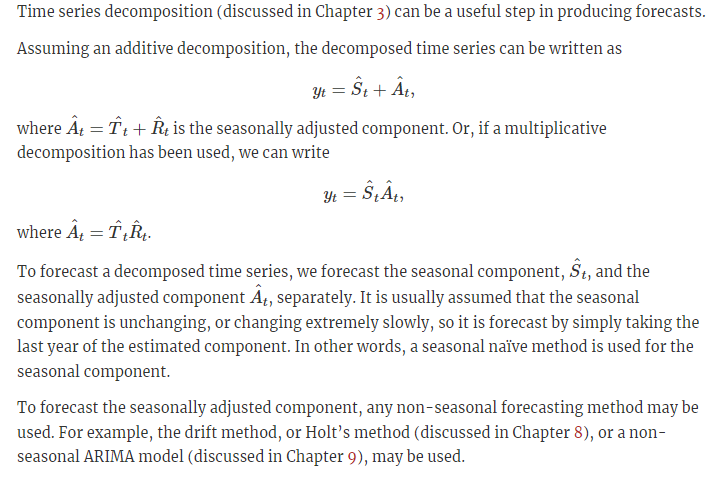

## the components of this time series are multiplicative

In [31]:
def parse(x):
    return datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv("./data/tourism.csv", parse_dates=["Quarter"], date_parser=parse)
df.drop(["Unnamed: 0", "Region", "State", "Purpose"], axis=1, inplace=True)
df = df.groupby("Quarter").sum().reset_index().set_index("Quarter")
df.sort_index(inplace=True)
df

,Trips
Quarter,
1998-01-01,23932.544141
1998-04-01,20856.726540
1998-07-01,20222.802189
1998-10-01,21342.960517
1999-01-01,22801.711403
...,...
2015-10-01,25759.429177
2016-01-01,27492.360374
2016-04-01,24791.797758


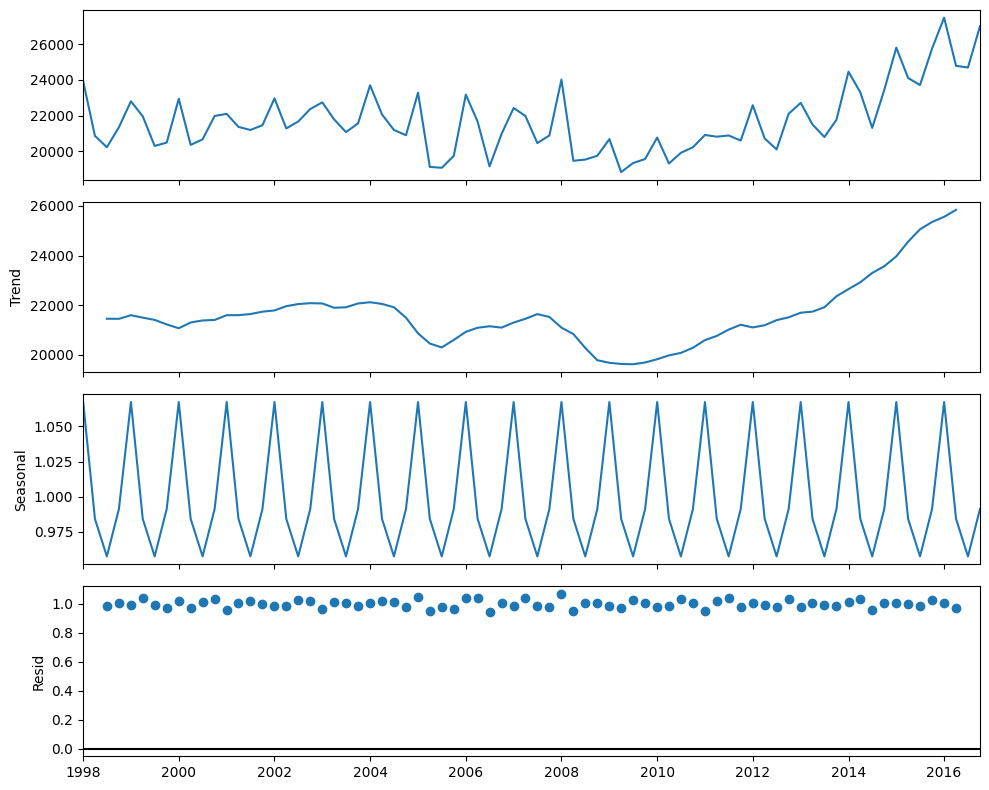

In [32]:
res = sm.tsa.seasonal_decompose(df, model="multiplicative", period=4)
resplot = res.plot()

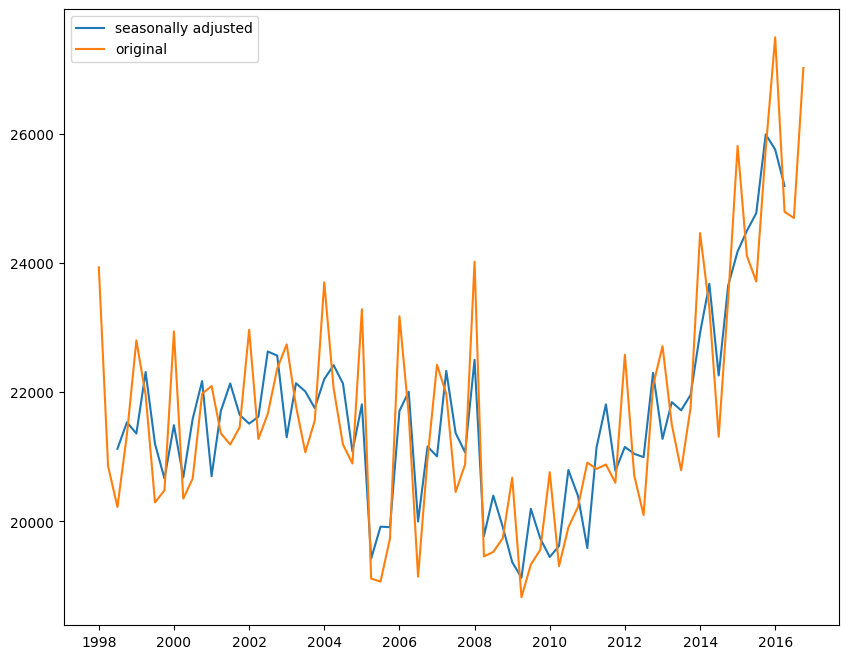

In [33]:
seasonally_adjusted = res.resid * res.trend
seasonally_adjusted.dropna(inplace=True)
plt.plot(seasonally_adjusted, label="seasonally adjusted")
plt.plot(df, label="original")
plt.legend(loc="best")
plt.show()

seasonally_adjusted_slope: -2.3040784515009625
seasonally_adjusted_std_hat: 1079.597887841515


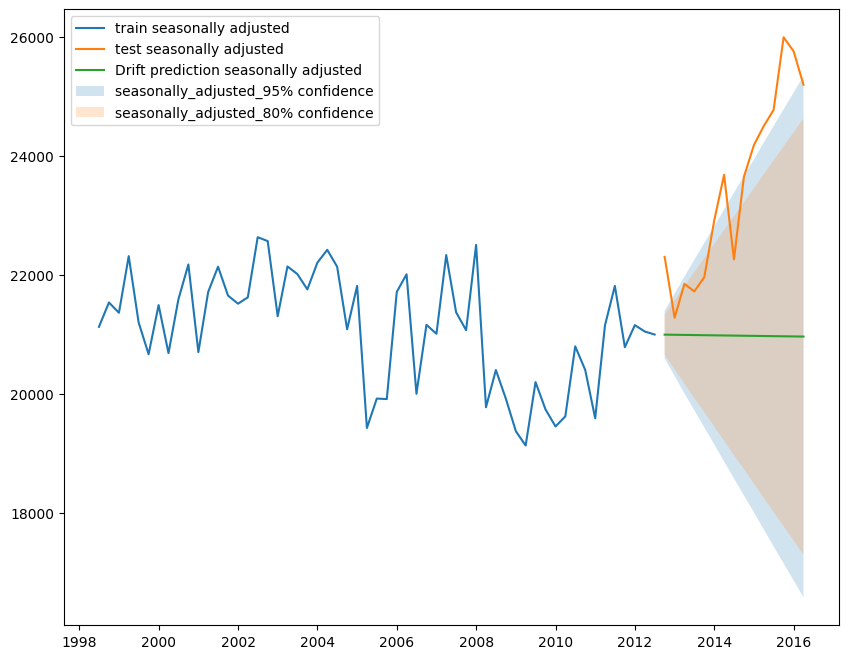

IndexError: single positional indexer is out-of-bounds

In [35]:
seasonally_adjusted = pd.DataFrame(seasonally_adjusted, index=seasonally_adjusted.index, columns=["Trips"])
St = pd.DataFrame(res.seasonal,index=res.seasonal.index,columns=["Trips"])
multiplier_95_percent = 1.96
multiplier_80_percent = 1.64
train = seasonally_adjusted.iloc[:int(len(seasonally_adjusted) * 0.8)]
test = seasonally_adjusted.iloc[int(len(seasonally_adjusted) * 0.8):]

T = len(train)
K = len(test)
M = 0
Yt = train.iloc[-1].values[0]
y1 = train.iloc[0].values[0]

print(f"seasonally_adjusted_slope: {(Yt - y1) / (T - 1)}")


def drift(y1, Yt, T, h):
    return Yt + (h * ((Yt - y1) / (T - 1)))

pred_train = train.copy()
for i in range(len(train)):
    pred_train.iloc[i] = drift(y1, Yt, T, (i + 1) - len(train))

resid_train = train - pred_train
std_hat = sqrt((1 / (T - K - M)) * np.sum(resid_train**2))
print(f"seasonally_adjusted_std_hat: {std_hat}")

test["seasonally_adjusted_upper_95%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            + ((multiplier_95_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["seasonally_adjusted_upper_80%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            + ((multiplier_80_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["seasonally_adjusted_lower_95%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            - ((multiplier_95_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["seasonally_adjusted_lower_80%"] = pd.Series(
    (
        [
            drift(y1, Yt, T, h)
            - ((multiplier_80_percent * std_hat) * sqrt(h * ((1 + h) / (T - 1))))
            for h in range(1, len(test) + 1)
        ]
    ),
    index=test.index,
)
test["seasonally_adjusted_pred"] = pd.Series(
    [drift(y1, Yt, T, h) for h in range(1, len(test) + 1)], index=test.index
)

plt.plot(train, label="train seasonally adjusted")
plt.plot(test.Trips, label="test seasonally adjusted")
plt.plot(test.seasonally_adjusted_pred, label="Drift prediction seasonally adjusted")
plt.fill_between(
    test.index,
    test["seasonally_adjusted_lower_95%"],
    test["seasonally_adjusted_upper_95%"],
    alpha=0.2,
    label="seasonally_adjusted_95% confidence",
)
plt.fill_between(
    test.index,
    test["seasonally_adjusted_lower_80%"],
    test["seasonally_adjusted_upper_80%"],
    alpha=0.2,
    label="seasonally_adjusted_80% confidence",
)
plt.legend(loc="best")
plt.show()


train = df.iloc[:int(len(df) * 0.8)]
test = df.iloc[int(len(df) * 0.8):]
df["pred"] = pd.Series(index=df.index)
j = 0
for i in range(len(df)):
    if i < len(train):
        df['pred'].iloc[i] = pred_train.iloc[i] * St.iloc[j]
    else:
        df['pred'].iloc[i] = test["seasonally_adjusted_pred"].iloc[i-len(train)] * St.iloc[j].values[0]
    j += 1
    if j == 4:
        j = 0


resid_train = train["Trips"] - pred_train['pred']
std_hat = sqrt((1 / (T - K - M)) * np.sum(resid_train**2))
print(f"std_hat: {std_hat}")

plt.plot(train["Trips"], label="train")
plt.plot(train["pred"], label="train pred")
plt.plot(test["Trips"], label="test")
plt.plot(test["pred"], label="test pred")
plt.legend(loc="best")
plt.show()